In [133]:
import os
from datetime import datetime, UTC
from pathlib import Path
import pickle

from fractal.loaders.base_loader import LoaderType
from fractal.loaders.thegraph import EthereumUniswapV3Loader

from plot import plot_history_with_pnl
from service import build_observations
from tau_agregator_strategy.avr_tau import TauResetPredict
from tau_agregator_strategy.oracle_strategy import OracleStrategy
from tau_agregator_strategy.tau_ensemble_strategy import TauEnsembleParams, TauEnsembleStrategy

In [134]:
THE_GRAPH_API_KEY = os.getenv('THE_GRAPH_API_KEY')

In [135]:
ticker: str = 'ETHUSDT'
pool_address: str = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'

token0_decimals, token1_decimals = EthereumUniswapV3Loader(
    THE_GRAPH_API_KEY, loader_type=LoaderType.CSV).get_pool_decimals(pool_address)

start_time = datetime(2024, 2, 5, tzinfo=UTC)
end_time = datetime(2024, 5, 5, tzinfo=UTC)
fidelity = 'hour'

observations = build_observations(ticker, pool_address, THE_GRAPH_API_KEY, start_time, end_time, fidelity=fidelity)

observation0 = observations[0]

Loading cached observations from cache/observations_ETHUSDT_0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8_hour_20240205_20240505.pkl


In [136]:
initial_balance = 1_000_000
ensemble_params: TauEnsembleParams = TauEnsembleParams(
    TAU=10,  # Tau value is the same as in the original strategy
    INITIAL_BALANCE=initial_balance
)

TauEnsembleStrategy.token0_decimals = token0_decimals
TauEnsembleStrategy.token1_decimals = token1_decimals
TauEnsembleStrategy.tick_spacing = 60
ensemble_strategy: TauEnsembleStrategy = TauEnsembleStrategy(
    oracul_strategy=OracleStrategy(),
    debug=True,
    params=ensemble_params
)

small = TauResetPredict(tau=5)
big = TauResetPredict(tau=30)

In [137]:
ensemble_strategy.add_model("tau_big", big.avr_tau_reset_predictor, 1)
ensemble_strategy.add_model("tau_small", small.avr_tau_reset_predictor, 1)

entities = ensemble_strategy.get_all_available_entities().keys()
assert all(entity in observation0.states for entity in entities)

In [138]:
print("Starting ensemble strategy (with one base model)...")
ensemble_result = ensemble_strategy.run(observations)
print("Ensemble strategy results:")
print(ensemble_result.get_default_metrics())

with open('ensemble_entity_history.pkl', 'wb') as f:
    pickle.dump(ensemble_strategy.entity_history, f)

file_name = 'tau_ensemble_result.csv'
ensemble_result.to_dataframe().to_csv(file_name)
print(ensemble_result.to_dataframe().iloc[-1])  # show the last state of the strategy

print("\nDone! Results saved to files tau_ensemble_result.csv and tau_strategy_result.csv")

Starting ensemble strategy (with one base model)...
Ensemble strategy results:
StrategyMetrics(accumulated_return=np.float64(0.11022074078703104), apy=np.float64(0.44700633763629255), sharpe=np.float64(1.1892003194726493), max_drawdown=np.float64(-0.3239242995030027))
timestamp                   2024-05-05 00:00:00+00:00
UNISWAP_V3_token0_amount                 223013.44941
UNISWAP_V3_token1_amount                   284.900818
UNISWAP_V3_price_init                          3164.6
UNISWAP_V3_price_lower                    3069.371104
UNISWAP_V3_price_upper                    3262.783424
UNISWAP_V3_liquidity            8618451244627756032.0
UNISWAP_V3_cash                           2000.507744
UNISWAP_V3_tvl                       350751033.682536
UNISWAP_V3_volume                         692957.5108
UNISWAP_V3_fees                           2078.872532
UNISWAP_V3_price                              3107.07
UNISWAP_V3_balance                     1110220.740787
net_balance                  

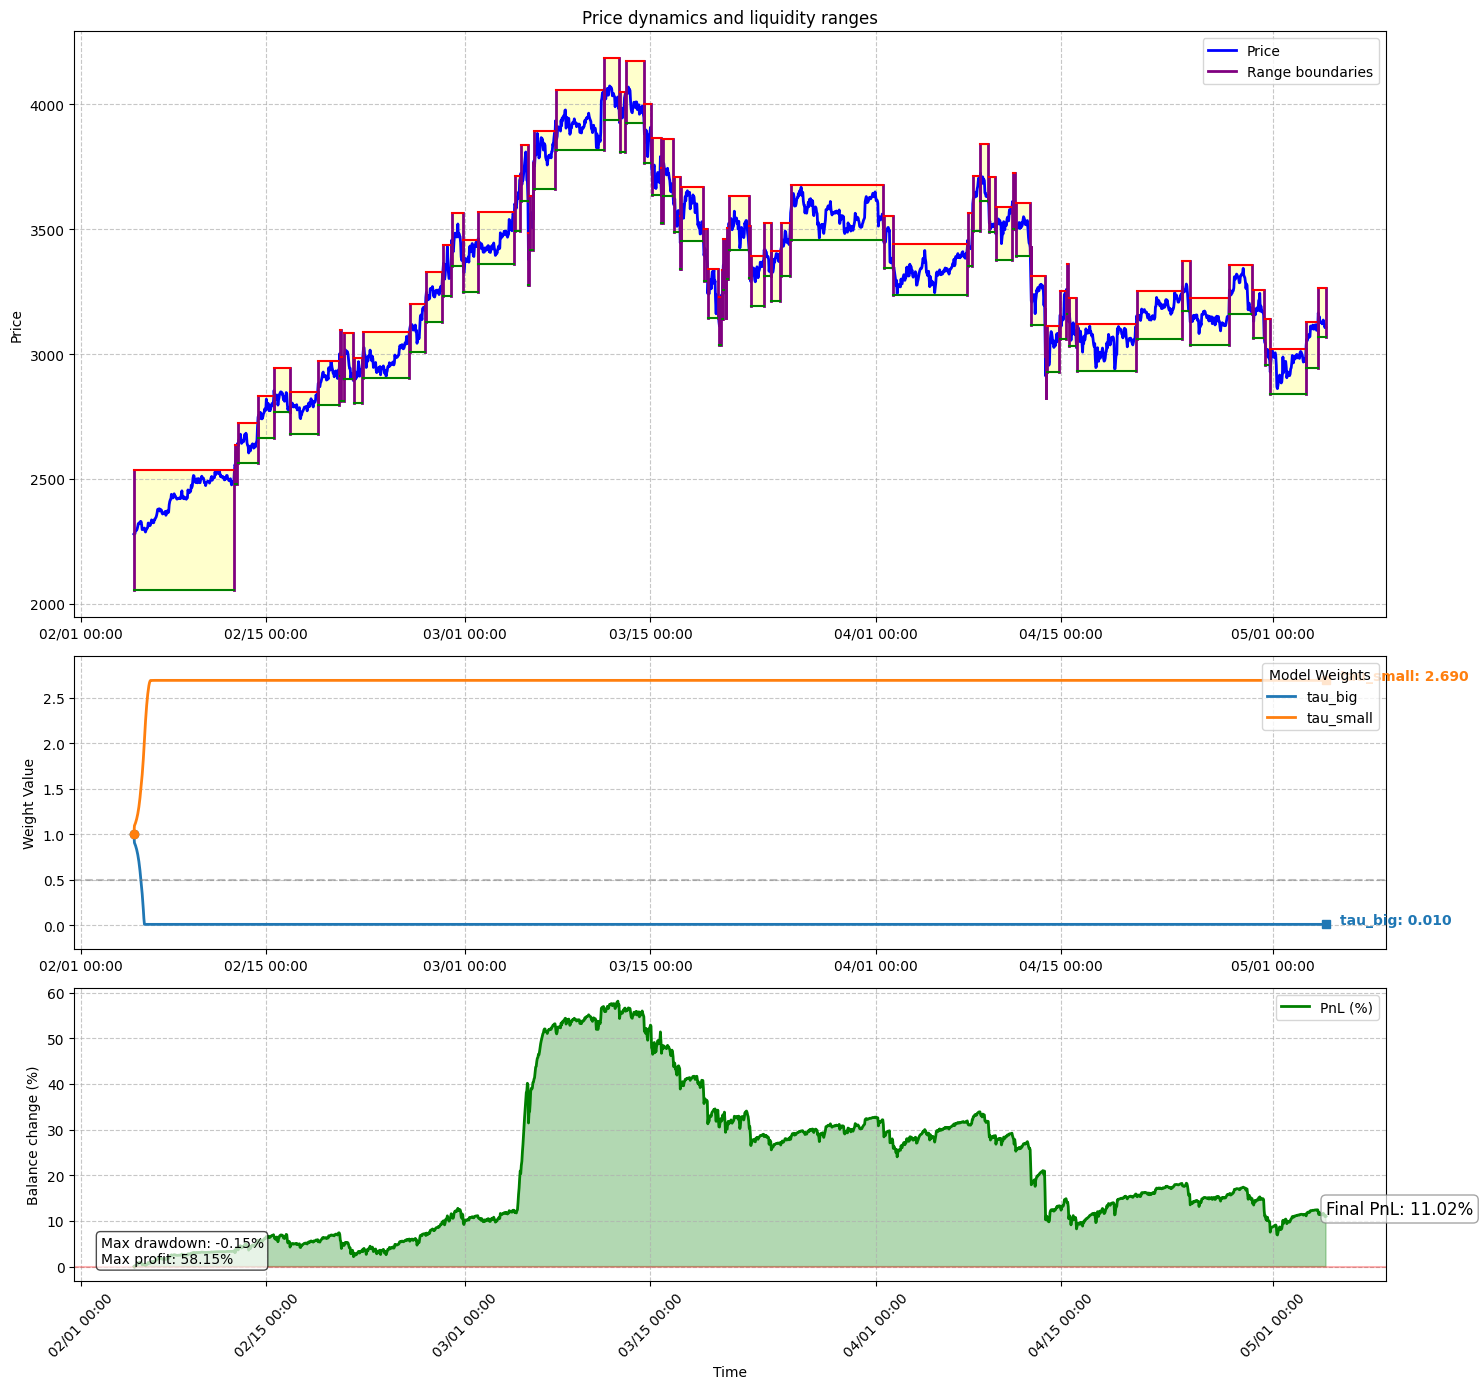

Profitability statistics:
Initial balance: 1000000.00
Final balance: 1110220.74
Change: 11.02%
Maximum drawdown: -0.15%
Maximum profit: 58.15%
Balance volatility: 15.78%
Total fees earned: 1363.22


In [139]:
# Visualize results
plot_history_with_pnl(file_name, initial_balance, ensemble_strategy.model_weights)